In [1]:
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams['figure.figsize'] = [2, 1]

In [2]:
from distr_tools import mixture_dist

In [3]:
import timeit
import scipy.linalg as spl
from scipy.spatial.distance import cdist

In [4]:
from sklearn import datasets

In [5]:
noisy_moons,moon_g = datasets.make_moons(n_samples=500, noise=0.05)

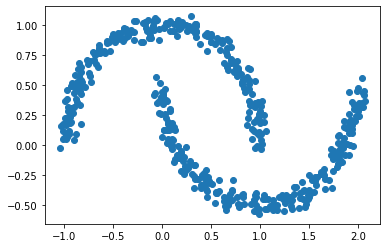

In [6]:
plt.scatter(*noisy_moons.T)

## Example Possible 1

In [7]:
lam1_init = sps.uniform(0,np.pi/np.sqrt(2))
lam2_init = sps.uniform(0,np.pi/np.sqrt(2))
r_init = sps.uniform(-1,2)

init_dists = [lam1_init,lam2_init,r_init]

In [8]:
n_init = 5000
init_sample = np.array([dist.rvs(n_init) for dist in init_dists]).T

In [9]:
def Q(lam):
    th = np.sqrt(lam.T[0]**2+lam.T[1]**2)
    r = lam.T[2]
    return np.stack([r*np.cos(th),r*np.sin(th)]).T

In [10]:
pred_sample = Q(init_sample)

In [11]:
pred_sample.shape

(5000, 2)

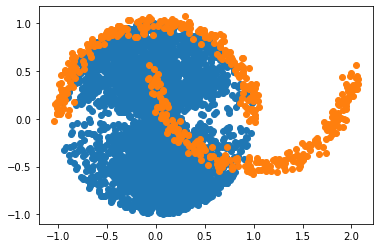

In [12]:
plt.scatter(*pred_sample.T)
plt.scatter(*noisy_moons.T)

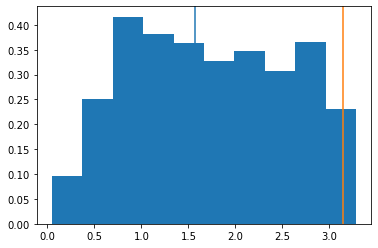

In [22]:
plt.hist(np.sqrt(init_sample.T[0]**2+init_sample.T[1]**2),density=True)
plt.axvline(np.pi/2)
plt.axvline(np.pi,c='C1')

## Example Possible 6

In [357]:
th_a,th_b = -np.pi/2,5*np.pi/2
th_init = sps.uniform(th_a,th_b-th_a)
r_init = sps.uniform(0.5,1)
g_init = mixture_dist([sps.norm(-1,0.15),sps.norm(1,0.15)],[0.5,0.5])
g_init = sps.uniform(-5,10)

init_dists = [th_init,r_init,g_init]

In [358]:
n_init = 5000
init_sample = np.array([dist.rvs(n_init) for dist in init_dists]).T

In [359]:
def Q(lam):
    th,r,g = lam.T
    center = np.array([1,0.5])*np.expand_dims(1/(1+np.exp(-0.5*g)),1)
#     center = np.array([1,0.5])+np.array([1,0.5])*np.expand_dims(g,1)
    s = 1.
    return np.stack([s*r*np.cos(th),s*r*np.sin(th)],axis=-1)+center,center

In [360]:
pred_sample,center = Q(init_sample)

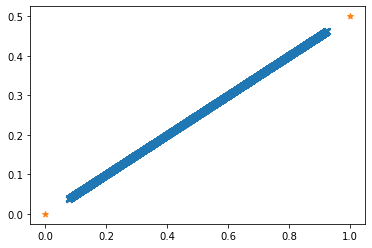

In [370]:
plt.scatter(*center.T,marker='x')
plt.scatter([0,1],[0,0.5],marker='*')

In [362]:
color_g = np.sign(0.5-init_sample[:,2])

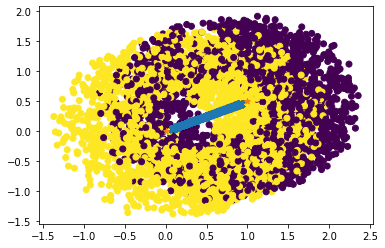

In [369]:
plt.scatter(*pred_sample.T,c=color_g)
plt.scatter(*center.T,marker='x')
plt.scatter([0,1],[0,0.5],marker='*')

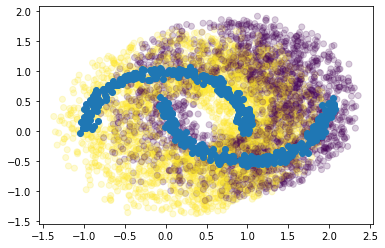

In [364]:
plt.scatter(*pred_sample.T,c=color_g,alpha=0.2)
plt.scatter(*noisy_moons.T)

In [317]:
this_moon = noisy_moons + 0*np.stack([-0.5*np.ones(len(noisy_moons)),np.zeros(len(noisy_moons))],axis=-1)
obs_kde = sps.gaussian_kde(this_moon.T,bw_method=0.20)
pred_kde = sps.gaussian_kde(pred_sample.T,bw_method=0.15)

In [304]:
qx,qy = [np.linspace(-2.,3.,150+i) for i in range(2)]
Qx,Qy = np.meshgrid(qx,qy)
Qxy_eval = np.stack([Qx.reshape(-1,),Qy.reshape(-1,)])

Qp_obs = obs_kde(Qxy_eval).reshape(Qx.shape)
Qp_pred = pred_kde(Qxy_eval).reshape(Qx.shape)

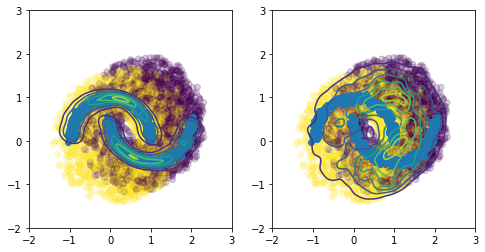

In [305]:
fig,axes = plt.subplots(1,2)
fig.set_figwidth(4*2)
for dist,ax in zip([Qp_obs,Qp_pred],axes):
    ax.scatter(*pred_sample.T,c=color_g,alpha=0.2)
    ax.scatter(*this_moon.T)
    ax.contour(Qx,Qy,dist)

In [306]:
this_r = obs_kde(pred_sample.T)/pred_kde(pred_sample.T)
print(this_r.mean())

0.9905527773402711


In [307]:
# accept-reject
M = np.max(this_r)
t = np.random.uniform(0,1,pred_sample.shape[0])
accept_reject = np.less_equal(t,this_r/M)
print('Accepted: ',np.sum(accept_reject))
print('Accept ratio: ',np.sum(accept_reject)/len(accept_reject))

update_sample = init_sample[accept_reject,:]

Accepted:  611
Accept ratio:  0.1222


In [308]:
init_sample.shape

(5000, 3)

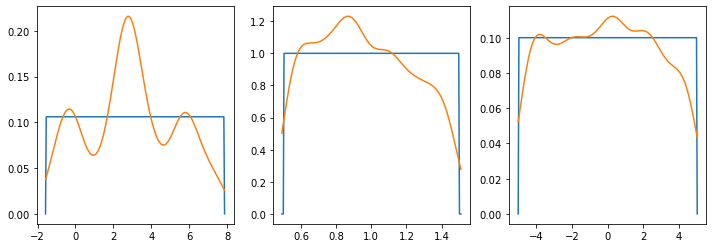

In [309]:
fig,axes = plt.subplots(1,len(init_dists))
fig.set_figwidth(len(init_dists)*4)
for i,ax in enumerate(axes):
    this_a,this_b = init_dists[i].support()
    this_x = np.linspace(this_a-1e-2,this_b+1e-2,250)
    ax.plot(this_x, init_dists[i].pdf(this_x))
    this_kde = sps.gaussian_kde(init_sample[:,i],weights=this_r)
    ax.plot(this_x,this_kde.pdf(this_x))

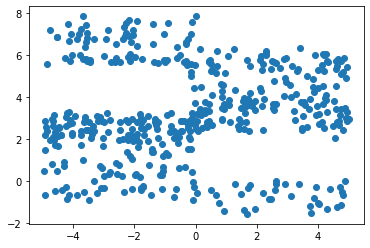

In [293]:
plt.scatter(update_sample[:,2],update_sample[:,0])

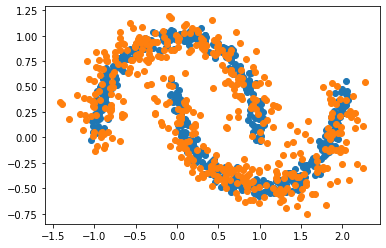

In [294]:
plt.scatter(*this_moon.T)
plt.scatter(*pred_sample[accept_reject,:].T)

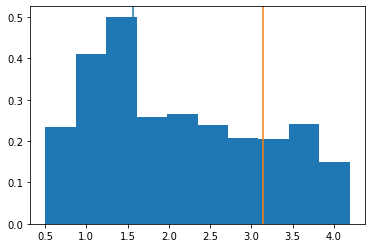

In [228]:
plt.hist(np.sqrt(init_sample.T[0]**2+init_sample.T[1]**2),density=True)
plt.axvline(np.pi/2)
plt.axvline(np.pi,c='C1')

## Example Possible 2

In [684]:
th_init = sps.uniform(0,2*np.pi)
r_init = sps.uniform(0.75,0.5)
# xeps_init = mixture_dist([sps.norm(0,0.15),sps.norm(1,0.15)],[0.5,0.5])#sps.uniform(-1,2)
# yeps_init = mixture_dist([sps.norm(0,0.15),sps.norm(0.5,0.15)],[0.5,0.5])
init_center = [np.zeros(2),np.array([1,0.5]),np.array([-1,0.5])]
center_dist = mixture_dist([sps.multivariate_normal(mu,0.005*np.eye(2)) for mu in init_center],
                           np.ones(len(init_center))/len(init_center),multi=True)

init_dists = [th_init,r_init,center_dist]

In [685]:
n_init = 5000
init_sample = np.column_stack([dist.rvs(n_init) for dist in init_dists])

In [686]:
init_sample.shape

(5000, 4)

In [687]:
def Q(lam):
    th,r,xeps,yeps = lam.T
    return np.stack([r*np.cos(th)+xeps,r*np.sin(th)+yeps]).T

In [688]:
pred_sample = Q(init_sample)

In [689]:
color_g = np.sign(init_sample[:,1])

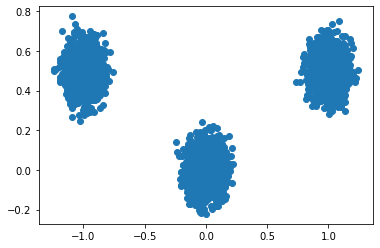

In [690]:
plt.scatter(init_sample[:,2],init_sample[:,3])

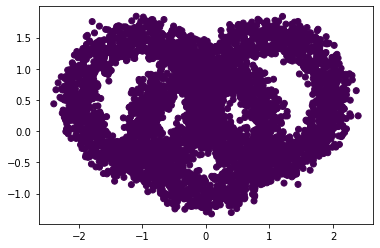

In [691]:
plt.scatter(*pred_sample.T,c=color_g)

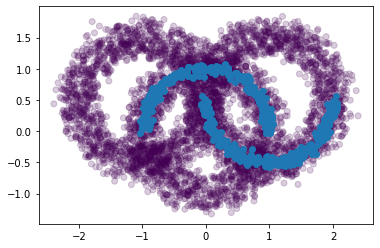

In [692]:
plt.scatter(*pred_sample.T,c=color_g,alpha=0.2)
plt.scatter(*noisy_moons.T)

In [703]:
this_moon = noisy_moons #+ np.stack([-0.5*np.ones(len(noisy_moons)),np.zeros(len(noisy_moons))],axis=-1)
obs_kde = sps.gaussian_kde(this_moon.T,bw_method=0.20)
pred_kde = sps.gaussian_kde(pred_sample.T,bw_method=0.12)

In [704]:
qx,qy = [np.linspace(-2,2,150+i) for i in range(2)]
Qx,Qy = np.meshgrid(qx,qy)
Qxy_eval = np.stack([Qx.reshape(-1,),Qy.reshape(-1,)])

Qp_obs = obs_kde(Qxy_eval).reshape(Qx.shape)
Qp_pred = pred_kde(Qxy_eval).reshape(Qx.shape)

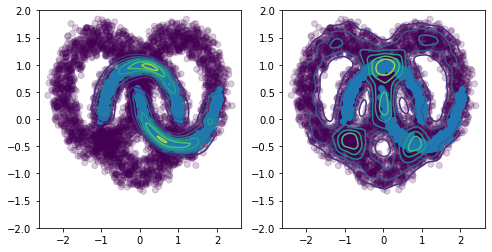

In [713]:
fig,axes = plt.subplots(1,2)
fig.set_figwidth(4*2)
for i,(dist,ax) in enumerate(zip([Qp_obs,Qp_pred],axes)):
    ax.scatter(*pred_sample.T,c=color_g,alpha=0.2)
    ax.scatter(*this_moon.T)
    ax.contour(Qx,Qy,dist)
#     if i==1:
#         t = pred_kde.resample(500).T
#         ax.scatter(*t.T,color='C1',alpha=0.5)

In [706]:
this_r = obs_kde(pred_sample.T)/pred_kde(pred_sample.T)
print(this_r.mean())

1.0262635963356364


In [707]:
# accept-reject
M = np.max(this_r)
t = np.random.uniform(0,1,pred_sample.shape[0])
accept_reject = np.less_equal(t,this_r/M)
print('Accepted: ',np.sum(accept_reject))
print('Accept ratio: ',np.sum(accept_reject)/len(accept_reject))

update_sample = init_sample[accept_reject,:]

Accepted:  887
Accept ratio:  0.1774


In [708]:
init_sample.shape

(5000, 4)

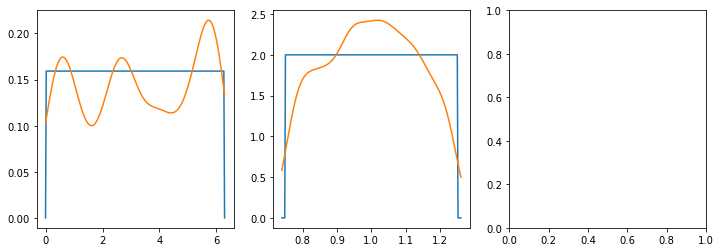

In [709]:
fig,axes = plt.subplots(1,len(init_dists))
fig.set_figwidth(len(init_dists)*4)
for i,ax in enumerate(axes):
    if i>1:
        continue
    try:
        this_a,this_b = init_dists[i].support()
    except:
        this_a,this_b = init_sample[:,i].min(),init_sample[:,i].max()
    this_x = np.linspace(this_a-1e-2,this_b+1e-2,250)
    ax.plot(this_x, init_dists[i].pdf(this_x))
    this_kde = sps.gaussian_kde(init_sample[:,i],weights=this_r)
    ax.plot(this_x,this_kde.pdf(this_x))

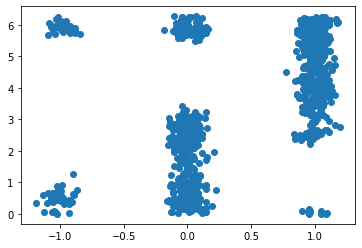

In [710]:
plt.scatter(update_sample[:,2],update_sample[:,0])

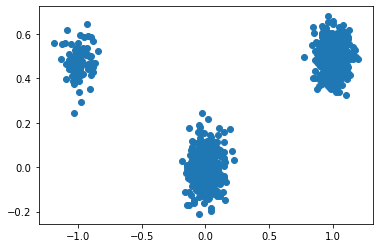

In [711]:
plt.scatter(update_sample[:,2],update_sample[:,3])

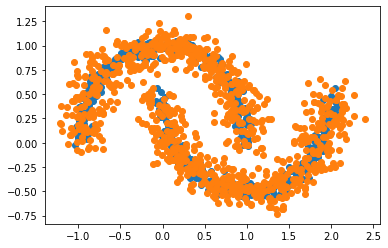

In [712]:
plt.scatter(*this_moon.T)
plt.scatter(*pred_sample[accept_reject,:].T)

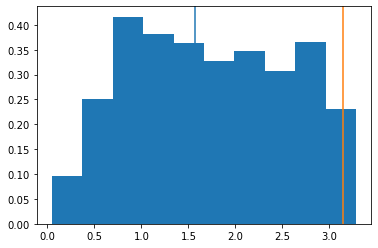

In [23]:
plt.hist(np.sqrt(init_sample.T[0]**2+init_sample.T[1]**2),density=True)
plt.axvline(np.pi/2)
plt.axvline(np.pi,c='C1')

## Example 3

In [124]:
r_init = sps.beta(2,2,loc=0,scale=2)
th_init = sps.uniform(-np.pi/2,np.pi)
xc_init = sps.uniform(-1,2)

init_dists = [r_init,th_init,xc_init]

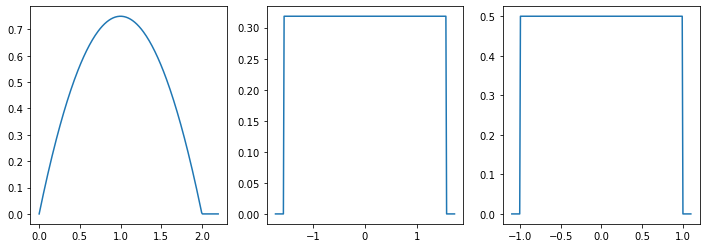

In [133]:
fig,axes = plt.subplots(1,len(init_dists))
fig.set_figwidth(4*len(init_dists))
for ax,dist in zip(axes,init_dists):
    xa,xb = dist.support()
    x = np.linspace(xa-0.1*np.abs(xa),xb+0.1*np.abs(xb),250)
    ax.plot(x,dist.pdf(x))

In [134]:
n_init = 5000
init_sample = np.array([dist.rvs(n_init) for dist in init_dists]).T

In [135]:
def Q(lam):
    r,th,xc = lam.T
    return np.stack([xc+np.sign(xc)*r*np.cos(th),np.sign(xc)*r*np.sin(th)]).T

In [136]:
pred_sample = Q(init_sample)

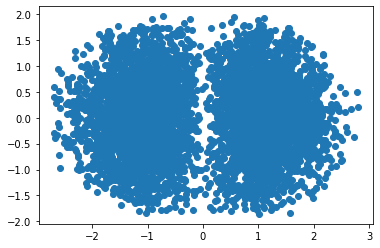

In [137]:
plt.scatter(*pred_sample.T)

In [227]:
xc_gen = mixture_dist([sps.uniform(c,0.1) for c in [-0.21,0.5]],[0.4,0.6])
r_gen_list = [sps.beta(6,6,loc=1,scale=1),sps.beta(6,3)]
th_gen_list = [sps.beta(5,2,loc=-np.pi/2,scale=np.pi),sps.beta(5,2,loc=-np.pi/2,scale=np.pi)]

gen_dist = [xc_gen,r_gen_list,th_gen_list]

def generate_sample(gen_dist,n):
    out_sample = np.empty([n,len(gen_dist)])
    out_sample[:,-1] = gen_dist[0].rvs(n)
    
    for i,dist in enumerate(gen_dist[1::]):
        ind = out_sample[:,-1] <= 0.
        out_sample[ind,i] = dist[0].rvs(sum(ind))
        out_sample[np.logical_not(ind),i] = dist[1].rvs(sum(np.logical_not(ind)))
        
    return out_sample

In [228]:
n_init = 5000
datagen_sample = generate_sample(gen_dist,n_init)

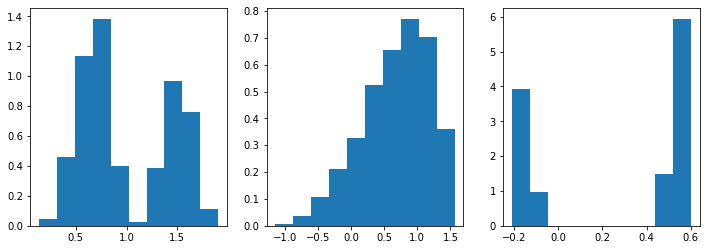

In [229]:
fig,axes = plt.subplots(1,len(init_dists))
fig.set_figwidth(4*len(init_dists))
for ax,samp in zip(axes,datagen_sample.T):
    ax.hist(samp,density=True)

Text(0, 0.5, '$\\theta$')

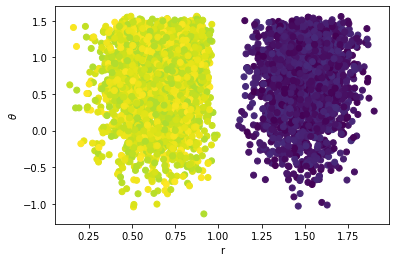

In [230]:
plt.scatter(*datagen_sample.T[0:-1],c=datagen_sample.T[-1])
plt.xlabel('r')
plt.ylabel('$\\theta$')

In [231]:
obs_sample = Q(datagen_sample)

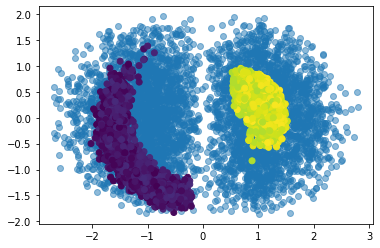

In [232]:
plt.scatter(*pred_sample.T,alpha=0.5)
plt.scatter(*obs_sample.T,c=datagen_sample.T[-1])


In [233]:
obs_kde = sps.gaussian_kde(obs_sample.T)
pred_kde = sps.gaussian_kde(pred_sample.T)

In [236]:
this_r = obs_kde(pred_sample.T)/pred_kde(pred_sample.T)
print(np.mean(this_r))

1.0680492331422744


In [237]:
# accept-reject
M = np.max(this_r)
t = np.random.uniform(0,1,pred_sample.shape[0])
accept_reject = np.less_equal(t,this_r/M)
print('Accepted: ',np.sum(accept_reject))
print('Accept ratio: ',np.sum(accept_reject)/len(accept_reject))

update_sample = init_sample[accept_reject,:]

Accepted:  763
Accept ratio:  0.1526


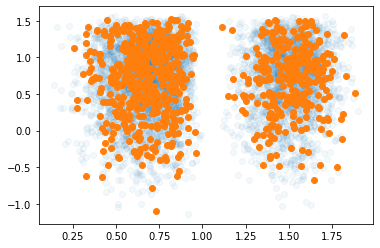

In [238]:
plt.scatter(datagen_sample[:,0],datagen_sample[:,1],alpha=0.05)
plt.scatter(update_sample[:,0],update_sample[:,1])


(-0.1, 0.01)

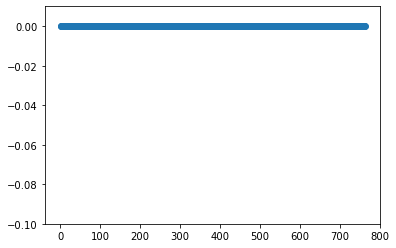

In [239]:
plt.scatter(np.arange(len(update_sample)),update_sample[:,-1])
plt.ylim(-0.1,0.01)